## Dependencies

In [87]:
import re
import warnings

import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import RepeatedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from xgboost import XGBRegressor

In [88]:
pd.set_option("display.max_rows", None, "display.max_columns", None) # Let pandas print the entire dataframe
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#todo: preprocessing like 

## Record Correct and Mismatched Data Type

In [89]:
# Set path of train, test data
data_train_path = r'D:\pythonProject\hello_fresh_go_tasks\model_and_data\b2b_data_train - b2b_data_train.csv'
data_test_path = r'D:\pythonProject\hello_fresh_go_tasks\model_and_data\b2b_data_test - b2b_data_test.csv'


# Load csv files into pandas dataframes
df_train = pd.read_csv(data_train_path)
df_test = pd.read_csv(data_test_path)


# Label column is the one absent from test data set.
global label_col_name
label_col_name = set(df_train.columns.values) - set(df_test.columns.values)

In [90]:
# We need to first identfy the type of each column for further processing.
# We have to copy and paste the column name from the index object rather than directly from the display. 

df_column_type = df_train.dtypes.to_frame(name = 'data_type')
df_data_sample = df_train.head(2).T 
df_data_sample = df_data_sample.rename(columns = {
                                                  0:'data_sample_0',
                                                  1:'data_sample_1'
                                                  })
df_check_data_type = df_column_type.join(df_data_sample)
display(df_check_data_type)

,data_type,data_sample_0,data_sample_1
Fridge ID,int64,5370,5637
City,object,Berlin,Berlin
Location,object,Central,Fringe
Year Founded,int64,2011,2016
Maturity,object,immature,immature
Industry,object,Service,Service
IndustryNew,object,E-Commerce,"B2C Software, Apps and Digital Services"
Company Type,object,Grownup,Startup
Company Type*,object,Mature Start-Up,Growing Start-Up
Employee Type,object,White Collar,White Collar


In [91]:
# Now we pick up the columns which has the correct and wrong formats, then categorize them.  

clean_int_columns = [
    'Fridge ID',
    'Year Founded',
    'Office Size'  
] 

clean_str_columns = [
    'City',
    'Location',
    'Maturity',
    'Industry',
    'IndustryNew',
    'Company Type',
    'Company Type*', 
    'Employee Type',
    'Innercompany Location',
    'Lead Source',
    'Fridge Type'  
] 

clean_float_columns = [
    
    'Registered Users',
    'Active users (weekly average 2019 per terminal)',
    'Basket size/User/Week', 'Male/Female Ratio',
    '# Newsletter subscriptions',
    '# Fingerprints',
    '# Restaurants nearby',
    'Avg. NPS Score'  
]

# There is an unwanted 'Û' in these columns
global columns_remove_U_and_convert_str_to_float 
columns_remove_U_and_convert_str_to_float = [
    'Service Fee', 
    'Subsidy', 
    'Revenue'
]

# We have to convert the str type to float type
global columns_remove_percentage_and_convert_str_to_float
columns_remove_percentage_and_convert_str_to_float = [
    'NL/User', 
    'FP/User'
]


checked_columns = [
    clean_int_columns,
    clean_str_columns,
    clean_float_columns,
    columns_remove_U_and_convert_str_to_float,
    columns_remove_percentage_and_convert_str_to_float
]

# Verify whether we have checked all the columns
total_num_columns = len(df_train.columns) 
checked_columns = [x for xs in checked_columns for x in xs]
num_missed_column = total_num_columns - len(checked_columns)

try:
    0 == num_missed_column
    print(f'We have checked all {total_num_columns} columns')
    
except ValueError:
    raise ValueError(f"We have missed to check {num_missed_column} columns")

We have checked all 27 columns


## Correct Mismatched Data Type

In [92]:
# We create a function to wrap ip the cleaning and encoding process and apply them to both train and test set.
# i.e., we need to creat several udf for pandas dataframe, although udf is slow applied to big dataframe. 

def func_remove_U_and_convert_str_to_float(cell):
    try:
        cell = re.sub('[^0-9.]', "", cell.replace(",","."))
        return float(cell)
    except:
        return np.nan   # missing value is casted to -1.
 
def func_remove_percentage_and_convert_str_to_float(cell):
    try:
        cell = cell.replace("%","")
        return float(cell)
    
    except:   
        return np.nan
    

def apply_udf(df,columns,func):
    for col in columns:
        df[col] = df.apply(lambda x: func(x[col]),axis = 1)
        
    return df


def clean_data(df,data_type):
   
    df = apply_udf(
        df,
        columns_remove_percentage_and_convert_str_to_float,
        func_remove_percentage_and_convert_str_to_float
    )
    
    if data_type == 'train':
        df = apply_udf(
            df,
            columns_remove_U_and_convert_str_to_float,
            func_remove_U_and_convert_str_to_float
        )
    elif data_type == 'test':
        df = apply_udf(
            df,
            set(columns_remove_U_and_convert_str_to_float) - label_col_name,
            func_remove_U_and_convert_str_to_float
        )
    else:
        raise ValueError("data_type input is wrong")
    
    return df

## Check Missing Value and Fill String Valued Column

In [93]:
def get_missing_value_percentage(df):
    percent_missing = df.isnull().sum() * 100 / len(df)
    missing_value_df = pd.DataFrame({
        'percent_missing': percent_missing
    })
    missing_value_df.sort_values('percent_missing', inplace=True)
    
    return missing_value_df


df_train = clean_data(df_train,'train')
df_test = clean_data(df_test,'test')

global numeric_colunms
global str_columns
numeric_colunms = set(checked_columns)\
               - set(clean_str_columns)
str_columns = clean_str_columns

global str_column_fillna_value
str_column_fillna_value = 'Unknown'

In [94]:
# We fill 'unknown' in the string valued column if the value is missing.
# we fill with the average value if the value is missing in that column.
     
        
def fill_missing_value(df,numeric_features,str_features):
    
    df_str = df[str_features]
    df_numeric = df[numeric_features]
    
    df_numeric = df_numeric.fillna(value=df_numeric.mean())
    df_str = df_str.fillna(value=str_column_fillna_value)
    df = pd.concat([df_numeric, df_str],axis=1)
    return df

## Check Correlation Between All Columns

In [95]:
# We use the whole training data to get the Heatmap matrix which gives us an overview of all pair correlations.
df_train = fill_missing_value(df_train, numeric_colunms,str_columns)   
df_test = fill_missing_value(df_test, numeric_colunms-label_col_name, str_columns) 
corr = df_train.corr()
display(corr)

,Subsidy,FP/User,NL/User,Revenue,# Newsletter subscriptions,Year Founded,Fridge ID,# Fingerprints,Basket size/User/Week,Male/Female Ratio,# Restaurants nearby,Service Fee,Office Size,Registered Users,Active users (weekly average 2019 per terminal),Avg. NPS Score
Subsidy,1.000000,0.123439,0.045030,0.273119,-0.067446,0.049700,-0.062084,-0.004526,0.195651,0.024339,-0.033123,0.088171,-0.160370,-0.073152,0.168224,0.053320
FP/User,0.123439,1.000000,0.261969,0.228317,0.041817,-0.051898,-0.187896,0.300165,0.070158,0.052112,-0.166167,-0.003535,-0.126899,-0.008235,0.201689,0.069560
NL/User,0.045030,0.261969,1.000000,0.001673,0.127295,-0.202475,0.094979,-0.073070,0.121355,-0.134380,-0.133312,0.103900,-0.036241,-0.100766,0.006375,0.225991
Revenue,0.273119,0.228317,0.001673,1.000000,0.377834,0.143770,-0.305169,0.504865,0.132400,-0.076353,-0.116038,0.025224,0.004965,0.309066,0.942982,0.108391
# Newsletter subscriptions,-0.067446,0.041817,0.127295,0.377834,1.000000,0.047212,-0.325508,0.838215,-0.274559,-0.108796,0.038703,0.078897,0.369071,0.931704,0.513393,0.147824
Year Founded,0.049700,-0.051898,-0.202475,0.143770,0.047212,1.000000,-0.037812,0.119853,-0.061810,-0.157158,0.181424,0.091055,-0.179148,0.117776,0.159023,-0.169206
Fridge ID,-0.062084,-0.187896,0.094979,-0.305169,-0.325508,-0.037812,1.000000,-0.383138,0.273732,0.074107,-0.136249,-0.032501,-0.129286,-0.330997,-0.349677,0.063821
# Fingerprints,-0.004526,0.300165,-0.073070,0.504865,0.838215,0.119853,-0.383138,1.000000,-0.262434,-0.058084,-0.020948,0.083479,0.248893,0.808139,0.619787,0.139418
Basket size/User/Week,0.195651,0.070158,0.121355,0.132400,-0.274559,-0.061810,0.273732,-0.262434,1.000000,0.071858,-0.199906,-0.087758,-0.156773,-0.271734,-0.122782,-0.002213
Male/Female Ratio,0.024339,0.052112,-0.134380,-0.076353,-0.108796,-0.157158,0.074107,-0.058084,0.071858,1.000000,-0.041986,-0.018165,0.130431,-0.090666,-0.095928,0.000287


In [96]:
# For now, we care about the correlation between the features and the to be predicted value.
# The correlation between 'Active users (weekly average 2019 per terminal)' and 'Revenue' is around 94%. 
display(df_train[df_train.columns[1:]].corr()[label_col_name][:-1].sort_values(by='Revenue',ascending=False))

,Revenue
Revenue,1.000000
Active users (weekly average 2019 per terminal),0.942982
# Fingerprints,0.504865
# Newsletter subscriptions,0.377834
Registered Users,0.309066
FP/User,0.228317
Year Founded,0.143770
Basket size/User/Week,0.132400
Service Fee,0.025224
Office Size,0.004965


<AxesSubplot:xlabel='{Revenue}', ylabel='Active users (weekly average 2019 per terminal)'>

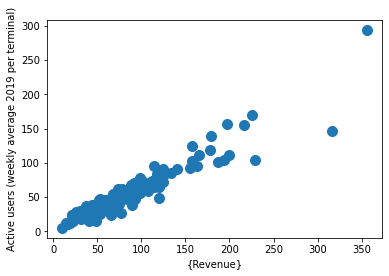

In [97]:
# Visually, we see that their relation is highly linear.
# i.e. the more the 'Active users (weekly average 2019 per terminal)' the more 'Revenue' will become.
df_train.plot.scatter(x = label_col_name, y = 'Active users (weekly average 2019 per terminal)', s = 100)

## Baseline Model: Linear Regression

In [106]:
# We see that the relation between these two columns is highly linear (correlation is ca.94%) 
# this suggests us to build a model using 'Active users (weekly average 2019 per terminal)' to predict 'Revenue'.
# In order to avoid data leakage, we will split the data into train, validation, test and process the data again.

data = pd.read_csv(data_train_path)
data = clean_data(data,'train')
(size_test_set,_) = pd.read_csv(data_test_path).shape
(size_train_set,_) = data.shape

In [107]:
# We choose str columns with number of unique value <=7, otherwise the resulted table is too sparse
display(data[str_columns].nunique().sort_values())
global str_columns_get_dummies
str_columns_get_dummies = [
    'Location',
    'Maturity',
    'Fridge Type',
    'City',    # we ignore the wired signs in the city names, since they do not bother us.
    'Employee Type' 
]
data_dummies = pd.get_dummies(data[str_columns_get_dummies])
dummies_columns = set(data_dummies.columns)
data = pd.concat([data, data_dummies],axis=1)

Location                  2
Maturity                  2
Fridge Type               2
Company Type*             4
City                      7
Employee Type             7
Lead Source              13
IndustryNew              15
Company Type             19
Industry                 27
Innercompany Location    28
dtype: int64

In [108]:
def get_loss(model,numeric_features,str_features,data,train_index,test_index):
    
    features = numeric_features|str_features
    train_data = data.iloc[train_index]
    test_data  = data.iloc[test_index]
    train_data = fill_missing_value(train_data,numeric_features,str_features)
    test_data = fill_missing_value(test_data,numeric_features,str_features)

    X_train = train_data[features-label_col_name]
    y_train = train_data[label_col_name]
    X_test = test_data[features-label_col_name]
    y_test = test_data[label_col_name]
    
    model = model.fit(X_train, y_train)
    train_y_pred = model.predict(X_train)
    test_y_pred = model.predict(X_test)
    
    train_msr = mean_squared_error(y_train, train_y_pred)
    test_msr = mean_squared_error(y_test, test_y_pred)
    return (train_msr,test_msr)


random_state = 12883823
# we set the n_splits as following to make sure that the size of the hold out set is euqal to the size of test data 
rkf = RepeatedKFold(n_splits=int(size_train_set/size_test_set), n_repeats=10, random_state=random_state)
n = 1

train_lr_baseline_loss = 0
train_lr_positive_corr_loss = 0
train_lr_all_features_loss = 0
train_xgb_reg_loss = 0

test_lr_baseline_loss = 0
test_lr_positive_corr_loss = 0
test_lr_all_features_loss = 0
test_xgb_reg_loss = 0


for train_index, test_index in rkf.split(data):
    
    lr = LinearRegression()
    xgb_reg = XGBRegressor()
    
    lr_baseline_features = set(['Active users (weekly average 2019 per terminal)']) \
                         | label_col_name
    
    lr_positive_corr_features = set([
                                    'Active users (weekly average 2019 per terminal)',
                                    '# Fingerprints',
                                    '# Newsletter subscriptions',
                                    'Registered Users',
                                    'Subsidy',
                                    'FP/User',
                                    'Year Founded',
                                    'Basket size/User/Week'
                                 ])\
                               | label_col_name
                               
    
    
   
    (temp_train_lr_baseline_loss,temp_test_lr_baseline_loss) = get_loss(
        model=lr,
        numeric_features=lr_baseline_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    train_lr_baseline_loss+=temp_train_lr_baseline_loss
    test_lr_baseline_loss+=temp_test_lr_baseline_loss
    
    (temp_train_lr_positive_corr_loss,temp_test_lr_positive_corr_loss) = get_loss(
        model=lr,
        numeric_features=lr_positive_corr_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_lr_positive_corr_loss+=temp_train_lr_positive_corr_loss
    test_lr_positive_corr_loss+=temp_test_lr_positive_corr_loss
    
    (temp_train_lr_all_features_loss,temp_test_lr_all_features_loss) = get_loss(
        model=lr,
        numeric_features=numeric_colunms,
        str_features = dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_lr_all_features_loss+=temp_train_lr_all_features_loss
    test_lr_all_features_loss+=temp_test_lr_all_features_loss
    
    (temp_train_xgb_reg_loss,temp_test_xgb_reg_loss)= get_loss(
        model=xgb_reg,
        numeric_features=numeric_colunms,
        str_features = set([]),#dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_xgb_reg_loss+=temp_train_xgb_reg_loss
    test_xgb_reg_loss+=temp_test_xgb_reg_loss
    
    n +=1

    
print('Train:',
      '-lr base line: ',round(train_lr_baseline_loss/n), 
      '-lr more features:',round(train_lr_positive_corr_loss/n),
      '-lr all features: ', round(train_lr_all_features_loss/n),
      '-xgb reg: ', round(train_xgb_reg_loss/n)
      )

print('Test:',
      '-lr base line: ',round(test_lr_baseline_loss/n), 
      '-lr more features:',round(test_lr_positive_corr_loss/n),
      '-lr all features: ', round(test_lr_all_features_loss/n),
      '-xgb reg: ', round(test_xgb_reg_loss/n)
      )

Train: -lr base line:  314 -lr more features: 110 -lr all features:  87 -xgb reg:  0
Test: -lr base line:  360 -lr more features: 181 -lr all features:  15549692040757088256 -xgb reg:  489


In [109]:
# Because linear regression is sensitive to outliers, after remove them we have a better result.
# remove revenue > 300 data points


data = pd.read_csv(data_train_path)
data = clean_data(data,'train')
(size_test_set,_) = pd.read_csv(data_test_path).shape
(size_train_set,_) = data.shape
data = data[data.Revenue<300]

global str_columns_get_dummies
str_columns_get_dummies = [
    'Location',
    'Maturity',
    'Fridge Type',
    'City',    # we ignore the wired signs in the city names, since they do not bother us.
    'Employee Type' 
]
data_dummies = pd.get_dummies(data[str_columns_get_dummies])
dummies_columns = set(data_dummies.columns)
data = pd.concat([data, data_dummies],axis=1)


def get_loss(model,numeric_features,str_features,data,train_index,test_index):
    
    features = numeric_features|str_features
    train_data = data.iloc[train_index]
    test_data  = data.iloc[test_index]
    train_data = fill_missing_value(train_data,numeric_features,str_features)
    test_data = fill_missing_value(test_data,numeric_features,str_features)

    X_train = train_data[features-label_col_name]
    y_train = train_data[label_col_name]
    X_test = test_data[features-label_col_name]
    y_test = test_data[label_col_name]
    
    model = model.fit(X_train, y_train)
    train_y_pred = model.predict(X_train)
    test_y_pred = model.predict(X_test)
    
    train_msr = mean_squared_error(y_train, train_y_pred)
    test_msr = mean_squared_error(y_test, test_y_pred)
    return (train_msr,test_msr)


random_state = 12883823
# we set the n_splits as following to make sure that the size of the hold out set is euqal to the size of test data 
# todo: shows that 3 can give stable train, test evaluation loss
rkf = RepeatedKFold(n_splits=int(size_train_set/size_test_set), n_repeats=3, random_state=random_state)
n = 1

train_lr_baseline_loss = 0
train_lr_positive_corr_loss = 0
train_lr_all_features_loss = 0
train_xgb_reg_loss = 0

test_lr_baseline_loss = 0
test_lr_positive_corr_loss = 0
test_lr_all_features_loss = 0
test_xgb_reg_loss = 0


for train_index, test_index in rkf.split(data):
    
    lr = LinearRegression()
    xgb_reg = XGBRegressor()
    
    lr_baseline_features = set(['Active users (weekly average 2019 per terminal)']) \
                         | label_col_name
    
    lr_positive_corr_features = set([
                                    'Active users (weekly average 2019 per terminal)',
                                    '# Fingerprints',
                                    '# Newsletter subscriptions',
                                    'Registered Users',
                                    'Subsidy',
                                    'FP/User',
                                    'Year Founded',
                                    'Basket size/User/Week'
                                 ])\
                               | label_col_name
                               
    
    
   
    (temp_train_lr_baseline_loss,temp_test_lr_baseline_loss) = get_loss(
        model=lr,
        numeric_features=lr_baseline_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    train_lr_baseline_loss+=temp_train_lr_baseline_loss
    test_lr_baseline_loss+=temp_test_lr_baseline_loss
    
    (temp_train_lr_positive_corr_loss,temp_test_lr_positive_corr_loss) = get_loss(
        model=lr,
        numeric_features=lr_positive_corr_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_lr_positive_corr_loss+=temp_train_lr_positive_corr_loss
    test_lr_positive_corr_loss+=temp_test_lr_positive_corr_loss
    
    (temp_train_lr_all_features_loss,temp_test_lr_all_features_loss) = get_loss(
        model=lr,
        numeric_features=numeric_colunms,
        str_features = dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_lr_all_features_loss+=temp_train_lr_all_features_loss
    test_lr_all_features_loss+=temp_test_lr_all_features_loss
    
    (temp_train_xgb_reg_loss,temp_test_xgb_reg_loss)= get_loss(
        model=xgb_reg,
        numeric_features=numeric_colunms,
        str_features = set([]),#dummies_columns,
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    train_xgb_reg_loss+=temp_train_xgb_reg_loss
    test_xgb_reg_loss+=temp_test_xgb_reg_loss
    
    n +=1

    
print('Train:',
      '-lr base line: ',round(train_lr_baseline_loss/n), 
      '-lr more features:',round(train_lr_positive_corr_loss/n),
      '-lr all features: ', round(train_lr_all_features_loss/n),
      '-xgb reg: ', round(train_xgb_reg_loss/n)
      )

print('Test:',
      '-lr base line: ',round(test_lr_baseline_loss/n), 
      '-lr more features:',round(test_lr_positive_corr_loss/n),
      '-lr all features: ', round(test_lr_all_features_loss/n),
      '-xgb reg: ', round(test_xgb_reg_loss/n)
      )

Train: -lr base line:  221 -lr more features: 61 -lr all features:  47 -xgb reg:  0
Test: -lr base line:  232 -lr more features: 92 -lr all features:  11904794902809554944 -xgb reg:  119


## Temporary Summary of Model Performance
As we have seen that the performance before removing outlier is:
<br>
Test: -lr base line:  360 -lr more features: 181 -lr all features:  15549692040757088256 - xgb reg:  489
<br>
After removing outlier is:
<br>
Test: -lr base line:  232 -lr more features: 92 -lr all features:  11904794902809554944 - xgb reg:  119
<br>
xgb reg is 300% better than before, yet lr more features is still the best one.<br>
prediction over train set of lr all features implies that we shall not use all features, but the one from the lr more features model. 
<br>
We will give a try of autoML with autokeras (autosklearn does not support windows which is a os system.).
<br>
Useing the following commands to install.
!pip install git+https://github.com/keras-team/keras-tuner.git
!pip install autokeras

In [ ]:
from autokeras import StructuredDataRegressor

data = pd.read_csv(data_train_path)
data = clean_data(data,'train')
(size_test_set,_) = pd.read_csv(data_test_path).shape
(size_train_set,_) = data.shape
data = data[data.Revenue<300]

global str_columns_get_dummies
str_columns_get_dummies = [
    'Location',
    'Maturity',
    'Fridge Type',
    'City',    # we ignore the wired signs in the city names, since they do not bother us.
    'Employee Type' 
]
data_dummies = pd.get_dummies(data[str_columns_get_dummies])
dummies_columns = set(data_dummies.columns)
data = pd.concat([data, data_dummies],axis=1)


def prepare_train_test(numeric_features,str_features,data,train_index,test_index):
    
    features = numeric_features|str_features
    train_data = data.iloc[train_index]
    test_data  = data.iloc[test_index]
    train_data = fill_missing_value(train_data,numeric_features,str_features)
    test_data = fill_missing_value(test_data,numeric_features,str_features)

    X_train = train_data[features-label_col_name]
    y_train = train_data[label_col_name]
    X_test = test_data[features-label_col_name]
    y_test = test_data[label_col_name]
    

    return X_train,y_train,X_test,y_test


random_state = 12883823
# we set the n_splits as following to make sure that the size of the hold out set is euqal to the size of test data 
rkf = RepeatedKFold(n_splits=int(size_train_set/size_test_set), n_repeats=3, random_state=random_state)
n = 1

train_auto_ml_loss = 0
test_auto_ml_loss = 0
train_lr_positive_corr_loss = 0
test_lr_positive_corr_loss = 0


for train_index, test_index in rkf.split(data):
    
    
    lr = LinearRegression()
    
    
    lr_positive_corr_features = set([
                                    'Active users (weekly average 2019 per terminal)',
                                    '# Fingerprints',
                                    '# Newsletter subscriptions',
                                    'Registered Users',
                                    'Subsidy',
                                    'FP/User',
                                    'Year Founded',
                                    'Basket size/User/Week'
                                 ])\
                               | label_col_name
    
    (temp_train_lr_positive_corr_loss,temp_test_lr_positive_corr_loss) = get_loss(
        model=lr,
        numeric_features=lr_positive_corr_features,
        str_features = set([]),
        data=data,
        train_index=train_index,
        test_index=test_index
    )
    
    train_lr_positive_corr_loss+=temp_train_lr_positive_corr_loss
    test_lr_positive_corr_loss+=temp_test_lr_positive_corr_loss
    
    
    
    X_train,y_train,X_test,y_test = prepare_train_test(
        numeric_features=numeric_colunms,
        str_features=set([]),
        data=data,
        train_index=train_index,
        test_index=test_index)
    
    search = StructuredDataRegressor(max_trials=30, loss='mean_absolute_error')
    search.fit(x=X_train, y=y_train, verbose=0)
    temp_train_auto_ml_loss,_ = search.evaluate(X_train, y_train, verbose=0)
    temp_test_auto_ml_loss,_ = search.evaluate(X_test, y_test, verbose=0)
    train_auto_ml_loss+=temp_train_auto_ml_loss
    test_auto_ml_loss+=temp_test_auto_ml_loss
    n+=1

INFO:tensorflow:Reloading Oracle from existing project .\structured_data_regressor\oracle.json
INFO:tensorflow:Reloading Tuner from .\structured_data_regressor\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/243
4/4 [==============================] - 1s 4ms/step - loss: 79.4259 - mean_squared_error: 8260.3535
Epoch 2/243
4/4 [==============================] - 0s 6ms/step - loss: 79.4091 - mean_squared_error: 8255.4922
Epoch 3/243
4/4 [==============================] - 0s 4ms/step - loss: 79.3245 - mean_squared_error: 8242.0166
Epoch 4/243
4/4 [==============================] - 0s 5ms/step - loss: 79.2627 - mean_squared_error: 8216.3213
Epoch 5/243
4/4 [==============================] - 0s 4ms/step - loss: 79.2707 - mean_squared_error: 8230.2168
Epoch 6/243
4/4 [==============================] - 0s 4ms/step - loss: 78.9859 - mean_squared_error: 8189.0742
Epoch 7/243
4/4 [==============================] - 0s 4ms/step - loss: 78.9544 - mean_squared_error: 8182.1001
Epoch 8/243
4

4/4 [==============================] - 0s 5ms/step - loss: 71.2989 - mean_squared_error: 7063.9580
Epoch 73/243
4/4 [==============================] - 0s 4ms/step - loss: 71.5032 - mean_squared_error: 7059.3276
Epoch 74/243
4/4 [==============================] - 0s 4ms/step - loss: 71.2020 - mean_squared_error: 7029.9189
Epoch 75/243
4/4 [==============================] - 0s 3ms/step - loss: 71.0558 - mean_squared_error: 6961.9814
Epoch 76/243
4/4 [==============================] - 0s 4ms/step - loss: 70.7887 - mean_squared_error: 6972.8286
Epoch 77/243
4/4 [==============================] - 0s 4ms/step - loss: 70.8354 - mean_squared_error: 6953.0225
Epoch 78/243
4/4 [==============================] - 0s 4ms/step - loss: 70.5942 - mean_squared_error: 6935.6982
Epoch 79/243
4/4 [==============================] - 0s 4ms/step - loss: 70.1191 - mean_squared_error: 6892.8569
Epoch 80/243
4/4 [==============================] - 0s 3ms/step - loss: 70.0590 - mean_squared_error: 6846.6074
Epoch

4/4 [==============================] - 0s 4ms/step - loss: 55.1845 - mean_squared_error: 4966.9756
Epoch 145/243
4/4 [==============================] - 0s 4ms/step - loss: 54.8540 - mean_squared_error: 4909.7275
Epoch 146/243
4/4 [==============================] - 0s 3ms/step - loss: 54.7130 - mean_squared_error: 4877.8330
Epoch 147/243
4/4 [==============================] - 0s 4ms/step - loss: 54.5953 - mean_squared_error: 4885.7827
Epoch 148/243
4/4 [==============================] - 0s 4ms/step - loss: 54.0024 - mean_squared_error: 4757.3237
Epoch 149/243
4/4 [==============================] - 0s 4ms/step - loss: 54.4815 - mean_squared_error: 4900.3486
Epoch 150/243
4/4 [==============================] - 0s 4ms/step - loss: 54.1952 - mean_squared_error: 4780.7261
Epoch 151/243
4/4 [==============================] - 0s 5ms/step - loss: 53.1088 - mean_squared_error: 4710.2261
Epoch 152/243
4/4 [==============================] - 0s 4ms/step - loss: 52.5030 - mean_squared_error: 4644.81

4/4 [==============================] - 0s 4ms/step - loss: 40.5363 - mean_squared_error: 3192.5208
Epoch 217/243
4/4 [==============================] - 0s 3ms/step - loss: 41.7559 - mean_squared_error: 3264.3044
Epoch 218/243
4/4 [==============================] - 0s 3ms/step - loss: 40.2304 - mean_squared_error: 3136.5571
Epoch 219/243
4/4 [==============================] - 0s 3ms/step - loss: 39.2698 - mean_squared_error: 2935.3496
Epoch 220/243
4/4 [==============================] - 0s 4ms/step - loss: 39.8243 - mean_squared_error: 3047.4224
Epoch 221/243
4/4 [==============================] - 0s 4ms/step - loss: 39.3864 - mean_squared_error: 2995.8853
Epoch 222/243
4/4 [==============================] - 0s 3ms/step - loss: 40.0315 - mean_squared_error: 3060.2905
Epoch 223/243
4/4 [==============================] - 0s 4ms/step - loss: 38.3652 - mean_squared_error: 3062.5725
Epoch 224/243
4/4 [==============================] - 0s 3ms/step - loss: 39.5070 - mean_squared_error: 3003.92

4/4 [==============================] - 0s 4ms/step - loss: 77.0030 - mean_squared_error: 8177.9590
Epoch 44/243
4/4 [==============================] - 0s 4ms/step - loss: 76.7879 - mean_squared_error: 8157.2666
Epoch 45/243
4/4 [==============================] - 0s 4ms/step - loss: 76.9333 - mean_squared_error: 8174.4863
Epoch 46/243
4/4 [==============================] - 0s 4ms/step - loss: 76.6365 - mean_squared_error: 8137.2622
Epoch 47/243
4/4 [==============================] - 0s 4ms/step - loss: 76.5415 - mean_squared_error: 8111.5371
Epoch 48/243
4/4 [==============================] - 0s 4ms/step - loss: 76.4975 - mean_squared_error: 8111.8291
Epoch 49/243
4/4 [==============================] - 0s 4ms/step - loss: 76.2862 - mean_squared_error: 8094.9131
Epoch 50/243
4/4 [==============================] - 0s 3ms/step - loss: 76.3282 - mean_squared_error: 8103.9756
Epoch 51/243
4/4 [==============================] - 0s 4ms/step - loss: 75.8941 - mean_squared_error: 8012.3838
Epoch

4/4 [==============================] - 0s 4ms/step - loss: 64.2853 - mean_squared_error: 6391.9497
Epoch 117/243
4/4 [==============================] - 0s 4ms/step - loss: 63.8240 - mean_squared_error: 6341.8843
Epoch 118/243
4/4 [==============================] - 0s 4ms/step - loss: 63.8016 - mean_squared_error: 6322.4839
Epoch 119/243
4/4 [==============================] - 0s 4ms/step - loss: 64.1983 - mean_squared_error: 6315.7515
Epoch 120/243
4/4 [==============================] - 0s 4ms/step - loss: 63.9671 - mean_squared_error: 6326.3125
Epoch 121/243
4/4 [==============================] - 0s 4ms/step - loss: 63.2429 - mean_squared_error: 6267.5767
Epoch 122/243
4/4 [==============================] - 0s 4ms/step - loss: 63.2115 - mean_squared_error: 6284.9502
Epoch 123/243
4/4 [==============================] - 0s 3ms/step - loss: 63.3573 - mean_squared_error: 6257.1665
Epoch 124/243
4/4 [==============================] - 0s 4ms/step - loss: 63.0678 - mean_squared_error: 6248.42

4/4 [==============================] - 0s 4ms/step - loss: 47.2204 - mean_squared_error: 4244.2109
Epoch 189/243
4/4 [==============================] - 0s 4ms/step - loss: 47.2018 - mean_squared_error: 4205.7822
Epoch 190/243
4/4 [==============================] - 0s 3ms/step - loss: 47.4354 - mean_squared_error: 4255.3174
Epoch 191/243
4/4 [==============================] - 0s 4ms/step - loss: 46.3297 - mean_squared_error: 4150.9561
Epoch 192/243
4/4 [==============================] - 0s 4ms/step - loss: 45.3905 - mean_squared_error: 4051.4868
Epoch 193/243
4/4 [==============================] - 0s 3ms/step - loss: 46.2727 - mean_squared_error: 4041.6838
Epoch 194/243
4/4 [==============================] - 0s 4ms/step - loss: 45.5072 - mean_squared_error: 4040.1001
Epoch 195/243
4/4 [==============================] - 0s 4ms/step - loss: 45.5428 - mean_squared_error: 4031.8567
Epoch 196/243
4/4 [==============================] - 0s 3ms/step - loss: 45.6358 - mean_squared_error: 3938.17

4/4 [==============================] - 0s 3ms/step - loss: 79.1583 - mean_squared_error: 8369.5234
Epoch 16/243
4/4 [==============================] - 0s 4ms/step - loss: 79.0705 - mean_squared_error: 8357.1250
Epoch 17/243
4/4 [==============================] - 0s 4ms/step - loss: 78.9394 - mean_squared_error: 8324.2217
Epoch 18/243
4/4 [==============================] - 0s 4ms/step - loss: 78.9096 - mean_squared_error: 8327.6816
Epoch 19/243
4/4 [==============================] - 0s 3ms/step - loss: 78.8748 - mean_squared_error: 8322.6270
Epoch 20/243
4/4 [==============================] - 0s 4ms/step - loss: 78.6849 - mean_squared_error: 8288.0488
Epoch 21/243
4/4 [==============================] - 0s 4ms/step - loss: 78.7148 - mean_squared_error: 8298.2998
Epoch 22/243
4/4 [==============================] - 0s 4ms/step - loss: 78.5975 - mean_squared_error: 8282.0254
Epoch 23/243
4/4 [==============================] - 0s 5ms/step - loss: 78.4857 - mean_squared_error: 8260.9561
Epoch

4/4 [==============================] - 0s 4ms/step - loss: 70.5375 - mean_squared_error: 7084.0757
Epoch 89/243
4/4 [==============================] - 0s 4ms/step - loss: 70.2082 - mean_squared_error: 7047.4531
Epoch 90/243
4/4 [==============================] - 0s 4ms/step - loss: 70.2203 - mean_squared_error: 7050.3032
Epoch 91/243
4/4 [==============================] - 0s 4ms/step - loss: 69.6414 - mean_squared_error: 6955.4233
Epoch 92/243
4/4 [==============================] - 0s 4ms/step - loss: 69.5730 - mean_squared_error: 6944.6851
Epoch 93/243
4/4 [==============================] - 0s 4ms/step - loss: 69.2942 - mean_squared_error: 6894.6533
Epoch 94/243
4/4 [==============================] - 0s 3ms/step - loss: 68.9183 - mean_squared_error: 6826.8198
Epoch 95/243
4/4 [==============================] - 0s 4ms/step - loss: 69.0658 - mean_squared_error: 6888.2153
Epoch 96/243
4/4 [==============================] - 0s 4ms/step - loss: 69.0784 - mean_squared_error: 6863.4834
Epoch

4/4 [==============================] - 0s 4ms/step - loss: 51.8075 - mean_squared_error: 4700.9072
Epoch 161/243
4/4 [==============================] - 0s 4ms/step - loss: 51.4186 - mean_squared_error: 4672.0942
Epoch 162/243
4/4 [==============================] - 0s 4ms/step - loss: 51.1259 - mean_squared_error: 4647.5928
Epoch 163/243
4/4 [==============================] - 0s 4ms/step - loss: 50.7472 - mean_squared_error: 4605.7456
Epoch 164/243
4/4 [==============================] - 0s 4ms/step - loss: 51.2970 - mean_squared_error: 4590.0977
Epoch 165/243
4/4 [==============================] - 0s 4ms/step - loss: 50.7935 - mean_squared_error: 4562.5991
Epoch 166/243
4/4 [==============================] - 0s 3ms/step - loss: 50.1611 - mean_squared_error: 4483.9829
Epoch 167/243
4/4 [==============================] - 0s 3ms/step - loss: 50.4116 - mean_squared_error: 4576.1841
Epoch 168/243
4/4 [==============================] - 0s 4ms/step - loss: 49.8760 - mean_squared_error: 4475.01

4/4 [==============================] - 0s 3ms/step - loss: 38.7178 - mean_squared_error: 2994.9861
Epoch 233/243
4/4 [==============================] - 0s 4ms/step - loss: 38.8097 - mean_squared_error: 3062.5012
Epoch 234/243
4/4 [==============================] - 0s 4ms/step - loss: 39.0562 - mean_squared_error: 3039.3538
Epoch 235/243
4/4 [==============================] - 0s 3ms/step - loss: 39.1466 - mean_squared_error: 3148.8335
Epoch 236/243
4/4 [==============================] - 0s 3ms/step - loss: 38.8769 - mean_squared_error: 3099.2900
Epoch 237/243
4/4 [==============================] - 0s 4ms/step - loss: 39.1375 - mean_squared_error: 3031.7737
Epoch 238/243
4/4 [==============================] - 0s 4ms/step - loss: 38.8919 - mean_squared_error: 3077.3896
Epoch 239/243
4/4 [==============================] - 0s 4ms/step - loss: 37.0026 - mean_squared_error: 2887.3499
Epoch 240/243
4/4 [==============================] - 0s 3ms/step - loss: 38.9939 - mean_squared_error: 3037.93

5/5 [==============================] - 0s 4ms/step - loss: 72.2967 - mean_squared_error: 7173.1089
Epoch 60/243
5/5 [==============================] - 0s 3ms/step - loss: 72.0613 - mean_squared_error: 7150.3901
Epoch 61/243
5/5 [==============================] - 0s 4ms/step - loss: 72.0614 - mean_squared_error: 7157.7695
Epoch 62/243
5/5 [==============================] - 0s 3ms/step - loss: 71.7168 - mean_squared_error: 7095.9990
Epoch 63/243
5/5 [==============================] - 0s 4ms/step - loss: 71.3200 - mean_squared_error: 7055.2983
Epoch 64/243
5/5 [==============================] - 0s 3ms/step - loss: 71.5161 - mean_squared_error: 7083.4458
Epoch 65/243
5/5 [==============================] - 0s 3ms/step - loss: 71.2810 - mean_squared_error: 7043.9780
Epoch 66/243
5/5 [==============================] - 0s 3ms/step - loss: 70.8945 - mean_squared_error: 6983.6802
Epoch 67/243
5/5 [==============================] - 0s 4ms/step - loss: 70.7909 - mean_squared_error: 6986.9512
Epoch

Epoch 132/243
5/5 [==============================] - 0s 4ms/step - loss: 54.6662 - mean_squared_error: 4920.6885
Epoch 133/243
5/5 [==============================] - 0s 3ms/step - loss: 54.2684 - mean_squared_error: 4840.5029
Epoch 134/243
5/5 [==============================] - 0s 3ms/step - loss: 54.4979 - mean_squared_error: 4924.4512
Epoch 135/243
5/5 [==============================] - 0s 3ms/step - loss: 54.1845 - mean_squared_error: 4838.0742
Epoch 136/243
5/5 [==============================] - 0s 3ms/step - loss: 53.9674 - mean_squared_error: 4829.3809
Epoch 137/243
5/5 [==============================] - 0s 3ms/step - loss: 54.1789 - mean_squared_error: 4868.0337
Epoch 138/243
5/5 [==============================] - 0s 3ms/step - loss: 53.6148 - mean_squared_error: 4750.5630
Epoch 139/243
5/5 [==============================] - 0s 4ms/step - loss: 52.7246 - mean_squared_error: 4670.2173
Epoch 140/243
5/5 [==============================] - 0s 3ms/step - loss: 52.5192 - mean_squared_

5/5 [==============================] - 0s 3ms/step - loss: 41.9677 - mean_squared_error: 3359.5552
Epoch 205/243
5/5 [==============================] - 0s 4ms/step - loss: 41.4214 - mean_squared_error: 3447.8774
Epoch 206/243
5/5 [==============================] - 0s 3ms/step - loss: 40.4818 - mean_squared_error: 3301.2458
Epoch 207/243
5/5 [==============================] - 0s 4ms/step - loss: 40.6248 - mean_squared_error: 3325.8708
Epoch 208/243
5/5 [==============================] - 0s 4ms/step - loss: 40.9648 - mean_squared_error: 3388.3706
Epoch 209/243
5/5 [==============================] - 0s 3ms/step - loss: 40.4670 - mean_squared_error: 3264.1179
Epoch 210/243
5/5 [==============================] - 0s 3ms/step - loss: 41.7418 - mean_squared_error: 3456.5784
Epoch 211/243
5/5 [==============================] - 0s 3ms/step - loss: 40.1683 - mean_squared_error: 3305.7383
Epoch 212/243
5/5 [==============================] - 0s 3ms/step - loss: 41.7034 - mean_squared_error: 3358.15

5/5 [==============================] - 0s 3ms/step - loss: 73.5754 - mean_squared_error: 7501.4937
Epoch 32/243
5/5 [==============================] - 0s 4ms/step - loss: 73.4708 - mean_squared_error: 7507.3472
Epoch 33/243
5/5 [==============================] - 0s 4ms/step - loss: 73.5252 - mean_squared_error: 7490.2925
Epoch 34/243
5/5 [==============================] - 0s 3ms/step - loss: 73.1917 - mean_squared_error: 7436.4741
Epoch 35/243
5/5 [==============================] - 0s 3ms/step - loss: 73.1455 - mean_squared_error: 7428.0503
Epoch 36/243
5/5 [==============================] - 0s 3ms/step - loss: 72.9965 - mean_squared_error: 7421.7705
Epoch 37/243
5/5 [==============================] - 0s 4ms/step - loss: 73.0193 - mean_squared_error: 7413.4834
Epoch 38/243
5/5 [==============================] - 0s 3ms/step - loss: 72.8470 - mean_squared_error: 7395.7856
Epoch 39/243
5/5 [==============================] - 0s 4ms/step - loss: 72.6077 - mean_squared_error: 7360.1240
Epoch

5/5 [==============================] - 0s 3ms/step - loss: 58.8989 - mean_squared_error: 5557.9243
Epoch 105/243
5/5 [==============================] - 0s 3ms/step - loss: 58.9540 - mean_squared_error: 5552.8315
Epoch 106/243
5/5 [==============================] - 0s 3ms/step - loss: 58.3194 - mean_squared_error: 5462.7271
Epoch 107/243
5/5 [==============================] - 0s 3ms/step - loss: 58.0881 - mean_squared_error: 5448.9775
Epoch 108/243
5/5 [==============================] - 0s 3ms/step - loss: 57.7145 - mean_squared_error: 5441.2910
Epoch 109/243
5/5 [==============================] - 0s 3ms/step - loss: 57.6581 - mean_squared_error: 5378.1323
Epoch 110/243
5/5 [==============================] - 0s 3ms/step - loss: 57.6346 - mean_squared_error: 5380.8965
Epoch 111/243
5/5 [==============================] - 0s 3ms/step - loss: 57.0665 - mean_squared_error: 5326.7671
Epoch 112/243
5/5 [==============================] - 0s 3ms/step - loss: 57.1492 - mean_squared_error: 5322.89

5/5 [==============================] - 0s 4ms/step - loss: 45.1758 - mean_squared_error: 3913.9470
Epoch 177/243
5/5 [==============================] - 0s 3ms/step - loss: 44.7644 - mean_squared_error: 3981.4854
Epoch 178/243
5/5 [==============================] - 0s 3ms/step - loss: 45.0335 - mean_squared_error: 3905.6707
Epoch 179/243
5/5 [==============================] - 0s 3ms/step - loss: 43.7388 - mean_squared_error: 3754.2588
Epoch 180/243
5/5 [==============================] - 0s 3ms/step - loss: 44.8036 - mean_squared_error: 3860.1709
Epoch 181/243
5/5 [==============================] - 0s 3ms/step - loss: 44.0081 - mean_squared_error: 3676.3594
Epoch 182/243
5/5 [==============================] - 0s 4ms/step - loss: 43.4536 - mean_squared_error: 3749.6934
Epoch 183/243
5/5 [==============================] - 0s 3ms/step - loss: 43.0370 - mean_squared_error: 3714.0518
Epoch 184/243
5/5 [==============================] - 0s 3ms/step - loss: 44.0956 - mean_squared_error: 3813.85

5/5 [==============================] - 0s 4ms/step - loss: 77.6544 - mean_squared_error: 7889.3755
Epoch 4/243
5/5 [==============================] - 0s 4ms/step - loss: 77.5239 - mean_squared_error: 7868.2847
Epoch 5/243
5/5 [==============================] - 0s 4ms/step - loss: 77.3909 - mean_squared_error: 7847.8999
Epoch 6/243
5/5 [==============================] - 0s 3ms/step - loss: 77.2691 - mean_squared_error: 7831.5508
Epoch 7/243
5/5 [==============================] - 0s 4ms/step - loss: 77.2783 - mean_squared_error: 7838.1895
Epoch 8/243
5/5 [==============================] - 0s 3ms/step - loss: 77.1655 - mean_squared_error: 7813.2300
Epoch 9/243
5/5 [==============================] - 0s 4ms/step - loss: 77.2176 - mean_squared_error: 7811.2339
Epoch 10/243
5/5 [==============================] - 0s 4ms/step - loss: 77.0415 - mean_squared_error: 7794.1592
Epoch 11/243
5/5 [==============================] - 0s 4ms/step - loss: 76.9967 - mean_squared_error: 7780.7983
Epoch 12/24

5/5 [==============================] - 0s 3ms/step - loss: 68.0645 - mean_squared_error: 6515.3320
Epoch 77/243
5/5 [==============================] - 0s 4ms/step - loss: 67.8492 - mean_squared_error: 6475.7085
Epoch 78/243
5/5 [==============================] - 0s 3ms/step - loss: 67.6744 - mean_squared_error: 6436.6523
Epoch 79/243
5/5 [==============================] - 0s 4ms/step - loss: 67.1691 - mean_squared_error: 6379.9551
Epoch 80/243
5/5 [==============================] - 0s 4ms/step - loss: 67.3794 - mean_squared_error: 6404.9087
Epoch 81/243
5/5 [==============================] - 0s 4ms/step - loss: 67.0324 - mean_squared_error: 6367.3149
Epoch 82/243
5/5 [==============================] - 0s 4ms/step - loss: 66.9611 - mean_squared_error: 6364.7070
Epoch 83/243
5/5 [==============================] - 0s 3ms/step - loss: 66.5735 - mean_squared_error: 6287.8945
Epoch 84/243
5/5 [==============================] - 0s 4ms/step - loss: 66.3231 - mean_squared_error: 6246.1533
Epoch

5/5 [==============================] - 0s 4ms/step - loss: 50.2137 - mean_squared_error: 4367.4531
Epoch 149/243
5/5 [==============================] - 0s 4ms/step - loss: 50.7825 - mean_squared_error: 4311.7671
Epoch 150/243
5/5 [==============================] - 0s 3ms/step - loss: 49.5644 - mean_squared_error: 4277.7578
Epoch 151/243
5/5 [==============================] - 0s 3ms/step - loss: 49.1603 - mean_squared_error: 4171.7026
Epoch 152/243
5/5 [==============================] - 0s 4ms/step - loss: 49.0667 - mean_squared_error: 4190.2896
Epoch 153/243
5/5 [==============================] - 0s 4ms/step - loss: 49.1403 - mean_squared_error: 4215.3652
Epoch 154/243
5/5 [==============================] - 0s 4ms/step - loss: 49.4523 - mean_squared_error: 4202.6133
Epoch 155/243
5/5 [==============================] - 0s 4ms/step - loss: 48.4912 - mean_squared_error: 4139.4106
Epoch 156/243
5/5 [==============================] - 0s 4ms/step - loss: 48.2546 - mean_squared_error: 4076.69

5/5 [==============================] - 0s 4ms/step - loss: 39.5369 - mean_squared_error: 3006.4814
Epoch 221/243
5/5 [==============================] - 0s 4ms/step - loss: 38.7757 - mean_squared_error: 2935.6733
Epoch 222/243
5/5 [==============================] - 0s 4ms/step - loss: 39.0889 - mean_squared_error: 2982.5542
Epoch 223/243
5/5 [==============================] - 0s 3ms/step - loss: 38.7726 - mean_squared_error: 2970.5154
Epoch 224/243
5/5 [==============================] - 0s 4ms/step - loss: 41.4328 - mean_squared_error: 3271.4531
Epoch 225/243
5/5 [==============================] - 0s 3ms/step - loss: 38.0959 - mean_squared_error: 2849.5950
Epoch 226/243
5/5 [==============================] - 0s 3ms/step - loss: 38.6946 - mean_squared_error: 2962.2827
Epoch 227/243
5/5 [==============================] - 0s 3ms/step - loss: 37.7656 - mean_squared_error: 2902.8799
Epoch 228/243
5/5 [==============================] - 0s 3ms/step - loss: 38.8815 - mean_squared_error: 2931.32

5/5 [==============================] - 0s 3ms/step - loss: 75.2797 - mean_squared_error: 7861.8755
Epoch 48/243
5/5 [==============================] - 0s 4ms/step - loss: 75.1673 - mean_squared_error: 7848.8604
Epoch 49/243
5/5 [==============================] - 0s 3ms/step - loss: 74.9726 - mean_squared_error: 7818.8467
Epoch 50/243
5/5 [==============================] - 0s 4ms/step - loss: 74.7799 - mean_squared_error: 7786.5513
Epoch 51/243
5/5 [==============================] - 0s 3ms/step - loss: 74.6415 - mean_squared_error: 7753.7319
Epoch 52/243
5/5 [==============================] - 0s 4ms/step - loss: 74.5786 - mean_squared_error: 7749.6626
Epoch 53/243
5/5 [==============================] - 0s 3ms/step - loss: 74.4388 - mean_squared_error: 7749.7715
Epoch 54/243
5/5 [==============================] - 0s 4ms/step - loss: 74.2765 - mean_squared_error: 7714.3325
Epoch 55/243
5/5 [==============================] - 0s 3ms/step - loss: 73.9795 - mean_squared_error: 7655.0371
Epoch

5/5 [==============================] - 0s 3ms/step - loss: 59.9365 - mean_squared_error: 5785.7266
Epoch 121/243
5/5 [==============================] - 0s 3ms/step - loss: 59.6673 - mean_squared_error: 5744.0674
Epoch 122/243
5/5 [==============================] - 0s 4ms/step - loss: 59.2218 - mean_squared_error: 5676.8892
Epoch 123/243
5/5 [==============================] - 0s 4ms/step - loss: 58.8064 - mean_squared_error: 5598.5923
Epoch 124/243
5/5 [==============================] - 0s 4ms/step - loss: 59.1770 - mean_squared_error: 5652.8320
Epoch 125/243
5/5 [==============================] - 0s 3ms/step - loss: 58.9333 - mean_squared_error: 5616.6216
Epoch 126/243
5/5 [==============================] - 0s 3ms/step - loss: 58.0307 - mean_squared_error: 5542.5215
Epoch 127/243
5/5 [==============================] - 0s 4ms/step - loss: 57.8936 - mean_squared_error: 5490.6011
Epoch 128/243
5/5 [==============================] - 0s 3ms/step - loss: 58.0799 - mean_squared_error: 5521.26

5/5 [==============================] - 0s 3ms/step - loss: 45.6311 - mean_squared_error: 4008.3916
Epoch 193/243
5/5 [==============================] - 0s 4ms/step - loss: 45.6360 - mean_squared_error: 3948.5781
Epoch 194/243
5/5 [==============================] - 0s 3ms/step - loss: 46.1882 - mean_squared_error: 4070.1506
Epoch 195/243
5/5 [==============================] - 0s 4ms/step - loss: 45.9713 - mean_squared_error: 3970.0178
Epoch 196/243
5/5 [==============================] - 0s 3ms/step - loss: 45.7626 - mean_squared_error: 4090.7583
Epoch 197/243
5/5 [==============================] - 0s 3ms/step - loss: 46.1227 - mean_squared_error: 4062.9185
Epoch 198/243
5/5 [==============================] - 0s 3ms/step - loss: 45.3850 - mean_squared_error: 4026.1550
Epoch 199/243
5/5 [==============================] - 0s 3ms/step - loss: 45.2271 - mean_squared_error: 4015.1917
Epoch 200/243
5/5 [==============================] - 0s 3ms/step - loss: 44.6322 - mean_squared_error: 3897.48

5/5 [==============================] - 0s 3ms/step - loss: 77.3827 - mean_squared_error: 8049.3682
Epoch 20/243
5/5 [==============================] - 0s 4ms/step - loss: 77.3747 - mean_squared_error: 8055.7451
Epoch 21/243
5/5 [==============================] - 0s 4ms/step - loss: 77.2693 - mean_squared_error: 8043.5552
Epoch 22/243
5/5 [==============================] - 0s 4ms/step - loss: 77.2122 - mean_squared_error: 8023.2256
Epoch 23/243
5/5 [==============================] - 0s 3ms/step - loss: 76.9796 - mean_squared_error: 7996.5386
Epoch 24/243
5/5 [==============================] - 0s 4ms/step - loss: 76.9251 - mean_squared_error: 7990.0005
Epoch 25/243
5/5 [==============================] - 0s 4ms/step - loss: 76.8247 - mean_squared_error: 7977.6626
Epoch 26/243
5/5 [==============================] - 0s 3ms/step - loss: 76.7503 - mean_squared_error: 7950.7817
Epoch 27/243
5/5 [==============================] - 0s 4ms/step - loss: 76.6102 - mean_squared_error: 7927.2583
Epoch

5/5 [==============================] - 0s 3ms/step - loss: 66.0962 - mean_squared_error: 6439.8506
Epoch 93/243
5/5 [==============================] - 0s 3ms/step - loss: 65.6562 - mean_squared_error: 6374.0293
Epoch 94/243
5/5 [==============================] - 0s 3ms/step - loss: 65.9230 - mean_squared_error: 6423.9795
Epoch 95/243
5/5 [==============================] - 0s 3ms/step - loss: 65.3150 - mean_squared_error: 6399.6699
Epoch 96/243
5/5 [==============================] - 0s 3ms/step - loss: 65.0299 - mean_squared_error: 6341.4912
Epoch 97/243
5/5 [==============================] - 0s 4ms/step - loss: 64.8779 - mean_squared_error: 6310.1089
Epoch 98/243
5/5 [==============================] - 0s 3ms/step - loss: 64.6940 - mean_squared_error: 6263.8379
Epoch 99/243
5/5 [==============================] - 0s 4ms/step - loss: 64.4412 - mean_squared_error: 6191.4834
Epoch 100/243
5/5 [==============================] - 0s 3ms/step - loss: 64.3577 - mean_squared_error: 6274.4629
Epoc

5/5 [==============================] - 0s 3ms/step - loss: 48.5630 - mean_squared_error: 4394.5371
Epoch 165/243
5/5 [==============================] - 0s 4ms/step - loss: 48.3209 - mean_squared_error: 4289.0059
Epoch 166/243
5/5 [==============================] - 0s 3ms/step - loss: 48.3335 - mean_squared_error: 4263.9019
Epoch 167/243
5/5 [==============================] - 0s 4ms/step - loss: 48.1422 - mean_squared_error: 4234.0024
Epoch 168/243
5/5 [==============================] - 0s 4ms/step - loss: 48.0375 - mean_squared_error: 4180.4585
Epoch 169/243
5/5 [==============================] - 0s 3ms/step - loss: 48.0419 - mean_squared_error: 4241.2104
Epoch 170/243
5/5 [==============================] - 0s 3ms/step - loss: 47.7385 - mean_squared_error: 4178.5391
Epoch 171/243
5/5 [==============================] - 0s 4ms/step - loss: 47.1124 - mean_squared_error: 4143.0771
Epoch 172/243
5/5 [==============================] - 0s 3ms/step - loss: 47.0141 - mean_squared_error: 4182.81

5/5 [==============================] - 0s 3ms/step - loss: 39.1211 - mean_squared_error: 3130.6177
Epoch 237/243
5/5 [==============================] - 0s 3ms/step - loss: 39.1225 - mean_squared_error: 3083.0398
Epoch 238/243
5/5 [==============================] - 0s 4ms/step - loss: 38.8035 - mean_squared_error: 3168.5864
Epoch 239/243
5/5 [==============================] - 0s 3ms/step - loss: 39.0505 - mean_squared_error: 3135.2744
Epoch 240/243
5/5 [==============================] - 0s 4ms/step - loss: 38.4630 - mean_squared_error: 3020.8088
Epoch 241/243
5/5 [==============================] - 0s 3ms/step - loss: 37.1906 - mean_squared_error: 2927.2483
Epoch 242/243
5/5 [==============================] - 0s 3ms/step - loss: 38.6583 - mean_squared_error: 3187.3403
Epoch 243/243
5/5 [==============================] - 0s 3ms/step - loss: 38.1265 - mean_squared_error: 3048.9492
INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets
INFO:tensorflow:Reloading Ora

4/4 [==============================] - 0s 4ms/step - loss: 73.6317 - mean_squared_error: 7446.2061
Epoch 64/243
4/4 [==============================] - 0s 4ms/step - loss: 73.2423 - mean_squared_error: 7368.7993
Epoch 65/243
4/4 [==============================] - 0s 4ms/step - loss: 73.0823 - mean_squared_error: 7365.4980
Epoch 66/243
4/4 [==============================] - 0s 4ms/step - loss: 72.7421 - mean_squared_error: 7306.6338
Epoch 67/243
4/4 [==============================] - 0s 3ms/step - loss: 72.8698 - mean_squared_error: 7356.6499
Epoch 68/243
4/4 [==============================] - 0s 5ms/step - loss: 72.6098 - mean_squared_error: 7297.0801
Epoch 69/243
4/4 [==============================] - 0s 4ms/step - loss: 72.5723 - mean_squared_error: 7284.0259
Epoch 70/243
4/4 [==============================] - 0s 3ms/step - loss: 72.3330 - mean_squared_error: 7230.8140
Epoch 71/243
4/4 [==============================] - 0s 4ms/step - loss: 72.0683 - mean_squared_error: 7206.3447
Epoch

4/4 [==============================] - 0s 4ms/step - loss: 57.8437 - mean_squared_error: 5413.6006
Epoch 136/243
4/4 [==============================] - 0s 4ms/step - loss: 58.1025 - mean_squared_error: 5397.6172
Epoch 137/243
4/4 [==============================] - 0s 5ms/step - loss: 57.5588 - mean_squared_error: 5347.6152
Epoch 138/243
4/4 [==============================] - 0s 4ms/step - loss: 57.7724 - mean_squared_error: 5375.0762
Epoch 139/243
4/4 [==============================] - 0s 4ms/step - loss: 56.9876 - mean_squared_error: 5270.7705
Epoch 140/243
4/4 [==============================] - 0s 4ms/step - loss: 56.7628 - mean_squared_error: 5218.6553
Epoch 141/243
4/4 [==============================] - 0s 4ms/step - loss: 56.8768 - mean_squared_error: 5249.7720
Epoch 142/243
4/4 [==============================] - 0s 4ms/step - loss: 56.7475 - mean_squared_error: 5219.0464
Epoch 143/243
4/4 [==============================] - 0s 4ms/step - loss: 56.1688 - mean_squared_error: 5101.28

4/4 [==============================] - 0s 4ms/step - loss: 42.5236 - mean_squared_error: 3476.9675
Epoch 208/243
4/4 [==============================] - 0s 4ms/step - loss: 42.5664 - mean_squared_error: 3366.9451
Epoch 209/243
4/4 [==============================] - 0s 4ms/step - loss: 42.3728 - mean_squared_error: 3377.5989
Epoch 210/243
4/4 [==============================] - 0s 4ms/step - loss: 41.8817 - mean_squared_error: 3413.6836
Epoch 211/243
4/4 [==============================] - 0s 4ms/step - loss: 42.7865 - mean_squared_error: 3461.8855
Epoch 212/243
4/4 [==============================] - 0s 4ms/step - loss: 41.6242 - mean_squared_error: 3424.8611
Epoch 213/243
4/4 [==============================] - 0s 4ms/step - loss: 42.2731 - mean_squared_error: 3428.1323
Epoch 214/243
4/4 [==============================] - 0s 4ms/step - loss: 42.1224 - mean_squared_error: 3396.9243
Epoch 215/243
4/4 [==============================] - 0s 4ms/step - loss: 40.8970 - mean_squared_error: 3240.41

4/4 [==============================] - 0s 4ms/step - loss: 75.1774 - mean_squared_error: 7748.3545
Epoch 35/243
4/4 [==============================] - 0s 4ms/step - loss: 74.9901 - mean_squared_error: 7728.7900
Epoch 36/243
4/4 [==============================] - 0s 4ms/step - loss: 74.6628 - mean_squared_error: 7664.4580
Epoch 37/243
4/4 [==============================] - 0s 4ms/step - loss: 74.9077 - mean_squared_error: 7724.1763
Epoch 38/243
4/4 [==============================] - 0s 4ms/step - loss: 74.7635 - mean_squared_error: 7702.4941
Epoch 39/243
4/4 [==============================] - 0s 4ms/step - loss: 74.5480 - mean_squared_error: 7650.2007
Epoch 40/243
4/4 [==============================] - 0s 4ms/step - loss: 74.4782 - mean_squared_error: 7654.4658
Epoch 41/243
4/4 [==============================] - 0s 4ms/step - loss: 74.4822 - mean_squared_error: 7641.8511
Epoch 42/243
4/4 [==============================] - 0s 4ms/step - loss: 74.3613 - mean_squared_error: 7618.4795
Epoch

4/4 [==============================] - 0s 4ms/step - loss: 63.3709 - mean_squared_error: 6113.5000
Epoch 108/243
4/4 [==============================] - 0s 3ms/step - loss: 63.0746 - mean_squared_error: 6083.5605
Epoch 109/243
4/4 [==============================] - 0s 4ms/step - loss: 63.2081 - mean_squared_error: 6138.1016
Epoch 110/243
4/4 [==============================] - 0s 4ms/step - loss: 63.1409 - mean_squared_error: 6083.8193
Epoch 111/243
4/4 [==============================] - 0s 4ms/step - loss: 62.3259 - mean_squared_error: 6036.4775
Epoch 112/243
4/4 [==============================] - 0s 5ms/step - loss: 62.5647 - mean_squared_error: 6007.4834
Epoch 113/243
4/4 [==============================] - 0s 3ms/step - loss: 61.8153 - mean_squared_error: 5938.0913
Epoch 114/243
4/4 [==============================] - 0s 4ms/step - loss: 62.1194 - mean_squared_error: 5926.3345
Epoch 115/243
4/4 [==============================] - 0s 4ms/step - loss: 61.4929 - mean_squared_error: 5910.73

4/4 [==============================] - 0s 4ms/step - loss: 46.4670 - mean_squared_error: 4084.7351
Epoch 180/243
4/4 [==============================] - 0s 4ms/step - loss: 45.8024 - mean_squared_error: 3970.3711
Epoch 181/243
4/4 [==============================] - 0s 4ms/step - loss: 45.7287 - mean_squared_error: 3963.0708
Epoch 182/243
4/4 [==============================] - 0s 3ms/step - loss: 46.3515 - mean_squared_error: 3922.6650
Epoch 183/243
4/4 [==============================] - 0s 4ms/step - loss: 46.8817 - mean_squared_error: 4046.5017
Epoch 184/243
4/4 [==============================] - 0s 4ms/step - loss: 44.4252 - mean_squared_error: 3839.1284
Epoch 185/243
4/4 [==============================] - 0s 5ms/step - loss: 45.6680 - mean_squared_error: 3882.4600
Epoch 186/243
4/4 [==============================] - 0s 4ms/step - loss: 45.1654 - mean_squared_error: 3872.7036
Epoch 187/243
4/4 [==============================] - 0s 4ms/step - loss: 44.3616 - mean_squared_error: 3757.79

4/4 [==============================] - 0s 3ms/step - loss: 79.7522 - mean_squared_error: 8600.1250
Epoch 7/243
4/4 [==============================] - 0s 4ms/step - loss: 79.6908 - mean_squared_error: 8596.8896
Epoch 8/243
4/4 [==============================] - 0s 3ms/step - loss: 79.6542 - mean_squared_error: 8589.7158
Epoch 9/243
4/4 [==============================] - 0s 4ms/step - loss: 79.5127 - mean_squared_error: 8561.6982
Epoch 10/243
4/4 [==============================] - 0s 3ms/step - loss: 79.5215 - mean_squared_error: 8575.0332
Epoch 11/243
4/4 [==============================] - 0s 4ms/step - loss: 79.3271 - mean_squared_error: 8536.3750
Epoch 12/243
4/4 [==============================] - 0s 4ms/step - loss: 79.1837 - mean_squared_error: 8508.4473
Epoch 13/243
4/4 [==============================] - 0s 4ms/step - loss: 79.1331 - mean_squared_error: 8500.9404
Epoch 14/243
4/4 [==============================] - 0s 4ms/step - loss: 79.0658 - mean_squared_error: 8490.5352
Epoch 15

4/4 [==============================] - 0s 4ms/step - loss: 71.0536 - mean_squared_error: 7289.2612
Epoch 80/243
4/4 [==============================] - 0s 3ms/step - loss: 71.2000 - mean_squared_error: 7305.4961
Epoch 81/243
4/4 [==============================] - 0s 4ms/step - loss: 70.8707 - mean_squared_error: 7280.1924
Epoch 82/243
4/4 [==============================] - 0s 4ms/step - loss: 70.7511 - mean_squared_error: 7247.4775
Epoch 83/243
4/4 [==============================] - 0s 4ms/step - loss: 70.2049 - mean_squared_error: 7181.1689
Epoch 84/243
4/4 [==============================] - 0s 4ms/step - loss: 70.2171 - mean_squared_error: 7180.6890
Epoch 85/243
4/4 [==============================] - 0s 3ms/step - loss: 70.2677 - mean_squared_error: 7179.7959
Epoch 86/243
4/4 [==============================] - 0s 4ms/step - loss: 70.0701 - mean_squared_error: 7158.4106
Epoch 87/243
4/4 [==============================] - 0s 4ms/step - loss: 69.7247 - mean_squared_error: 7109.6162
Epoch

4/4 [==============================] - 0s 4ms/step - loss: 54.8717 - mean_squared_error: 5124.2412
Epoch 152/243
4/4 [==============================] - 0s 4ms/step - loss: 54.7593 - mean_squared_error: 5138.2866
Epoch 153/243
4/4 [==============================] - 0s 4ms/step - loss: 54.8739 - mean_squared_error: 5154.7207
Epoch 154/243
4/4 [==============================] - 0s 4ms/step - loss: 53.8332 - mean_squared_error: 5033.8965
Epoch 155/243
4/4 [==============================] - 0s 4ms/step - loss: 54.1897 - mean_squared_error: 4992.1455
Epoch 156/243
4/4 [==============================] - 0s 4ms/step - loss: 53.3225 - mean_squared_error: 4968.0015
Epoch 157/243
4/4 [==============================] - 0s 4ms/step - loss: 52.5920 - mean_squared_error: 4933.3604
Epoch 158/243
4/4 [==============================] - 0s 4ms/step - loss: 52.4578 - mean_squared_error: 4869.8892
Epoch 159/243
4/4 [==============================] - 0s 4ms/step - loss: 52.3511 - mean_squared_error: 4735.05

4/4 [==============================] - 0s 4ms/step - loss: 41.8003 - mean_squared_error: 3370.9700
Epoch 223/243
4/4 [==============================] - 0s 4ms/step - loss: 41.0383 - mean_squared_error: 3345.4736
Epoch 224/243
4/4 [==============================] - 0s 3ms/step - loss: 42.0917 - mean_squared_error: 3442.8965
Epoch 225/243
4/4 [==============================] - 0s 3ms/step - loss: 41.0333 - mean_squared_error: 3314.1489
Epoch 226/243
4/4 [==============================] - 0s 4ms/step - loss: 41.4989 - mean_squared_error: 3370.8176
Epoch 227/243
4/4 [==============================] - 0s 3ms/step - loss: 40.3280 - mean_squared_error: 3241.8987
Epoch 228/243
4/4 [==============================] - 0s 4ms/step - loss: 39.8968 - mean_squared_error: 3206.4534
Epoch 229/243
4/4 [==============================] - 0s 4ms/step - loss: 40.6297 - mean_squared_error: 3309.8596
Epoch 230/243
4/4 [==============================] - 0s 4ms/step - loss: 39.5802 - mean_squared_error: 3184.08

5/5 [==============================] - 0s 4ms/step - loss: 74.2168 - mean_squared_error: 7450.2373
Epoch 50/243
5/5 [==============================] - 0s 3ms/step - loss: 73.8920 - mean_squared_error: 7420.4312
Epoch 51/243
5/5 [==============================] - 0s 3ms/step - loss: 73.8806 - mean_squared_error: 7433.3589
Epoch 52/243
5/5 [==============================] - 0s 4ms/step - loss: 73.7288 - mean_squared_error: 7381.5166
Epoch 53/243
5/5 [==============================] - 0s 6ms/step - loss: 73.7237 - mean_squared_error: 7400.6641
Epoch 54/243
5/5 [==============================] - 0s 4ms/step - loss: 73.6301 - mean_squared_error: 7392.0161
Epoch 55/243
5/5 [==============================] - 0s 4ms/step - loss: 73.3133 - mean_squared_error: 7330.1953
Epoch 56/243
5/5 [==============================] - 0s 4ms/step - loss: 73.0657 - mean_squared_error: 7312.3447
Epoch 57/243
5/5 [==============================] - 0s 3ms/step - loss: 72.9033 - mean_squared_error: 7281.0215
Epoch

5/5 [==============================] - 0s 3ms/step - loss: 57.1759 - mean_squared_error: 5205.9565
Epoch 123/243
5/5 [==============================] - 0s 4ms/step - loss: 57.6083 - mean_squared_error: 5249.2188
Epoch 124/243
5/5 [==============================] - 0s 3ms/step - loss: 57.4196 - mean_squared_error: 5176.0742
Epoch 125/243
5/5 [==============================] - 0s 3ms/step - loss: 57.2109 - mean_squared_error: 5180.9966
Epoch 126/243
5/5 [==============================] - 0s 3ms/step - loss: 56.7619 - mean_squared_error: 5154.2607
Epoch 127/243
5/5 [==============================] - 0s 4ms/step - loss: 56.5079 - mean_squared_error: 5113.4980
Epoch 128/243
5/5 [==============================] - 0s 3ms/step - loss: 56.2091 - mean_squared_error: 5109.4614
Epoch 129/243
5/5 [==============================] - 0s 3ms/step - loss: 56.5024 - mean_squared_error: 5085.6963
Epoch 130/243
5/5 [==============================] - 0s 3ms/step - loss: 55.6949 - mean_squared_error: 5026.41

5/5 [==============================] - 0s 3ms/step - loss: 44.6157 - mean_squared_error: 3544.7766
Epoch 195/243
5/5 [==============================] - 0s 4ms/step - loss: 44.6151 - mean_squared_error: 3639.2908
Epoch 196/243
5/5 [==============================] - 0s 4ms/step - loss: 43.2614 - mean_squared_error: 3542.1477
Epoch 197/243
5/5 [==============================] - 0s 3ms/step - loss: 44.6486 - mean_squared_error: 3636.0151
Epoch 198/243
5/5 [==============================] - 0s 4ms/step - loss: 43.6621 - mean_squared_error: 3563.0430
Epoch 199/243
5/5 [==============================] - 0s 3ms/step - loss: 43.5937 - mean_squared_error: 3507.5017
Epoch 200/243
5/5 [==============================] - 0s 3ms/step - loss: 44.3649 - mean_squared_error: 3527.5798
Epoch 201/243
5/5 [==============================] - 0s 3ms/step - loss: 43.7226 - mean_squared_error: 3596.6533
Epoch 202/243
5/5 [==============================] - 0s 4ms/step - loss: 43.0779 - mean_squared_error: 3531.17

5/5 [==============================] - 0s 4ms/step - loss: 74.5948 - mean_squared_error: 7627.8740
Epoch 22/243
5/5 [==============================] - 0s 4ms/step - loss: 74.4262 - mean_squared_error: 7599.5483
Epoch 23/243
5/5 [==============================] - 0s 4ms/step - loss: 74.2552 - mean_squared_error: 7585.5615
Epoch 24/243
5/5 [==============================] - 0s 4ms/step - loss: 74.1444 - mean_squared_error: 7565.7129
Epoch 25/243
5/5 [==============================] - 0s 4ms/step - loss: 74.0279 - mean_squared_error: 7553.5342
Epoch 26/243
5/5 [==============================] - 0s 3ms/step - loss: 73.8838 - mean_squared_error: 7526.1416
Epoch 27/243
5/5 [==============================] - 0s 4ms/step - loss: 73.8996 - mean_squared_error: 7524.2954
Epoch 28/243
5/5 [==============================] - 0s 3ms/step - loss: 73.7277 - mean_squared_error: 7498.3062
Epoch 29/243
5/5 [==============================] - 0s 3ms/step - loss: 73.6146 - mean_squared_error: 7477.8569
Epoch

5/5 [==============================] - 0s 3ms/step - loss: 61.4344 - mean_squared_error: 5875.9917
Epoch 95/243
5/5 [==============================] - 0s 3ms/step - loss: 60.3491 - mean_squared_error: 5696.7661
Epoch 96/243
5/5 [==============================] - 0s 4ms/step - loss: 60.9485 - mean_squared_error: 5803.1284
Epoch 97/243
5/5 [==============================] - 0s 4ms/step - loss: 60.1333 - mean_squared_error: 5713.7373
Epoch 98/243
5/5 [==============================] - 0s 3ms/step - loss: 60.0810 - mean_squared_error: 5688.8286
Epoch 99/243
5/5 [==============================] - 0s 3ms/step - loss: 59.7992 - mean_squared_error: 5651.0610
Epoch 100/243
5/5 [==============================] - 0s 4ms/step - loss: 59.6248 - mean_squared_error: 5618.6621
Epoch 101/243
5/5 [==============================] - 0s 3ms/step - loss: 59.0536 - mean_squared_error: 5534.0083
Epoch 102/243
5/5 [==============================] - 0s 3ms/step - loss: 59.1045 - mean_squared_error: 5561.1182
Ep

5/5 [==============================] - 0s 4ms/step - loss: 46.4278 - mean_squared_error: 4053.5144
Epoch 167/243
5/5 [==============================] - 0s 3ms/step - loss: 45.9628 - mean_squared_error: 3965.2483
Epoch 168/243
5/5 [==============================] - 0s 4ms/step - loss: 45.1014 - mean_squared_error: 3903.7095
Epoch 169/243
5/5 [==============================] - 0s 3ms/step - loss: 45.6383 - mean_squared_error: 3960.2141
Epoch 170/243
5/5 [==============================] - 0s 4ms/step - loss: 45.2729 - mean_squared_error: 3905.9473
Epoch 171/243
5/5 [==============================] - 0s 3ms/step - loss: 45.9368 - mean_squared_error: 3968.9995
Epoch 172/243
5/5 [==============================] - 0s 4ms/step - loss: 45.2371 - mean_squared_error: 3854.6516
Epoch 173/243
5/5 [==============================] - 0s 3ms/step - loss: 44.9429 - mean_squared_error: 3974.9470
Epoch 174/243
5/5 [==============================] - 0s 4ms/step - loss: 45.2236 - mean_squared_error: 3904.42

5/5 [==============================] - 0s 4ms/step - loss: 39.3562 - mean_squared_error: 3100.4692
Epoch 239/243
5/5 [==============================] - 0s 3ms/step - loss: 40.0531 - mean_squared_error: 3194.1987
Epoch 240/243
5/5 [==============================] - 0s 3ms/step - loss: 38.7528 - mean_squared_error: 3113.4880
Epoch 241/243
5/5 [==============================] - 0s 4ms/step - loss: 39.5715 - mean_squared_error: 3188.1921
Epoch 242/243
5/5 [==============================] - 0s 4ms/step - loss: 38.8660 - mean_squared_error: 3074.5059
Epoch 243/243
5/5 [==============================] - 0s 4ms/step - loss: 38.8939 - mean_squared_error: 3034.5750
INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets
INFO:tensorflow:Reloading Oracle from existing project .\structured_data_regressor\oracle.json
INFO:tensorflow:Reloading Tuner from .\structured_data_regressor\tuner0.json
INFO:tensorflow:Oracle triggered exit
Epoch 1/243
5/5 [============================

5/5 [==============================] - 0s 3ms/step - loss: 72.9607 - mean_squared_error: 7437.0708
Epoch 66/243
5/5 [==============================] - 0s 3ms/step - loss: 72.9029 - mean_squared_error: 7422.1436
Epoch 67/243
5/5 [==============================] - 0s 4ms/step - loss: 72.7663 - mean_squared_error: 7438.4062
Epoch 68/243
5/5 [==============================] - 0s 4ms/step - loss: 72.4212 - mean_squared_error: 7352.1475
Epoch 69/243
5/5 [==============================] - 0s 4ms/step - loss: 72.3654 - mean_squared_error: 7344.4404
Epoch 70/243
5/5 [==============================] - 0s 4ms/step - loss: 72.0044 - mean_squared_error: 7277.3662
Epoch 71/243
5/5 [==============================] - 0s 4ms/step - loss: 71.9427 - mean_squared_error: 7276.5747
Epoch 72/243
5/5 [==============================] - 0s 4ms/step - loss: 71.6337 - mean_squared_error: 7245.4463
Epoch 73/243
5/5 [==============================] - 0s 3ms/step - loss: 71.4807 - mean_squared_error: 7214.5107
Epoch

5/5 [==============================] - 0s 4ms/step - loss: 56.7120 - mean_squared_error: 5253.9116
Epoch 138/243
5/5 [==============================] - 0s 3ms/step - loss: 56.6569 - mean_squared_error: 5343.1826
Epoch 139/243
5/5 [==============================] - 0s 4ms/step - loss: 55.6202 - mean_squared_error: 5144.5938
Epoch 140/243
5/5 [==============================] - 0s 3ms/step - loss: 55.6010 - mean_squared_error: 5124.7280
Epoch 141/243
5/5 [==============================] - 0s 4ms/step - loss: 54.6752 - mean_squared_error: 5003.3154
Epoch 142/243
5/5 [==============================] - 0s 4ms/step - loss: 55.3530 - mean_squared_error: 5108.4380
Epoch 143/243
5/5 [==============================] - 0s 4ms/step - loss: 55.1819 - mean_squared_error: 5143.0542
Epoch 144/243
5/5 [==============================] - 0s 4ms/step - loss: 54.9909 - mean_squared_error: 5102.8018
Epoch 145/243
5/5 [==============================] - 0s 3ms/step - loss: 54.9195 - mean_squared_error: 5121.41

5/5 [==============================] - 0s 4ms/step - loss: 43.6438 - mean_squared_error: 3680.2942
Epoch 210/243
5/5 [==============================] - 0s 4ms/step - loss: 43.4575 - mean_squared_error: 3774.7317
Epoch 211/243
5/5 [==============================] - 0s 4ms/step - loss: 43.5146 - mean_squared_error: 3617.0339
Epoch 212/243
5/5 [==============================] - 0s 4ms/step - loss: 41.7999 - mean_squared_error: 3560.2578
Epoch 213/243
5/5 [==============================] - 0s 4ms/step - loss: 41.9150 - mean_squared_error: 3578.1604
Epoch 214/243
5/5 [==============================] - 0s 4ms/step - loss: 42.0832 - mean_squared_error: 3573.8413
Epoch 215/243
5/5 [==============================] - 0s 4ms/step - loss: 42.1039 - mean_squared_error: 3575.6699
Epoch 216/243
5/5 [==============================] - 0s 4ms/step - loss: 43.0075 - mean_squared_error: 3671.9082
Epoch 217/243
5/5 [==============================] - 0s 4ms/step - loss: 42.7094 - mean_squared_error: 3752.45

5/5 [==============================] - 0s 4ms/step - loss: 75.2735 - mean_squared_error: 7843.1133
Epoch 37/243
5/5 [==============================] - 0s 4ms/step - loss: 75.2211 - mean_squared_error: 7834.9185
Epoch 38/243
5/5 [==============================] - 0s 4ms/step - loss: 75.0076 - mean_squared_error: 7809.0410
Epoch 39/243
5/5 [==============================] - 0s 3ms/step - loss: 75.0361 - mean_squared_error: 7823.8428
Epoch 40/243
5/5 [==============================] - 0s 3ms/step - loss: 74.8356 - mean_squared_error: 7766.0669
Epoch 41/243
5/5 [==============================] - 0s 4ms/step - loss: 74.6100 - mean_squared_error: 7745.5771
Epoch 42/243
5/5 [==============================] - 0s 4ms/step - loss: 74.7515 - mean_squared_error: 7772.1631
Epoch 43/243
5/5 [==============================] - 0s 3ms/step - loss: 74.3064 - mean_squared_error: 7697.7119
Epoch 44/243
5/5 [==============================] - 0s 3ms/step - loss: 74.1352 - mean_squared_error: 7671.7749
Epoch

5/5 [==============================] - 0s 4ms/step - loss: 60.4050 - mean_squared_error: 5809.4922
Epoch 110/243
5/5 [==============================] - 0s 3ms/step - loss: 59.5949 - mean_squared_error: 5709.5151
Epoch 111/243
5/5 [==============================] - 0s 4ms/step - loss: 59.7165 - mean_squared_error: 5703.3755
Epoch 112/243
5/5 [==============================] - 0s 5ms/step - loss: 59.2301 - mean_squared_error: 5702.2329
Epoch 113/243
5/5 [==============================] - 0s 4ms/step - loss: 58.7032 - mean_squared_error: 5610.7373
Epoch 114/243
5/5 [==============================] - 0s 4ms/step - loss: 58.6485 - mean_squared_error: 5593.6011
Epoch 115/243
5/5 [==============================] - 0s 3ms/step - loss: 58.7069 - mean_squared_error: 5593.6558
Epoch 116/243
5/5 [==============================] - 0s 4ms/step - loss: 58.6606 - mean_squared_error: 5616.1519
Epoch 117/243
5/5 [==============================] - 0s 3ms/step - loss: 58.1341 - mean_squared_error: 5476.43

5/5 [==============================] - 0s 4ms/step - loss: 46.5831 - mean_squared_error: 4061.8669
Epoch 182/243
5/5 [==============================] - 0s 4ms/step - loss: 45.4975 - mean_squared_error: 3901.7573
Epoch 183/243
5/5 [==============================] - 0s 4ms/step - loss: 45.9587 - mean_squared_error: 4035.8792
Epoch 184/243
5/5 [==============================] - 0s 3ms/step - loss: 45.0009 - mean_squared_error: 3963.5498
Epoch 185/243
5/5 [==============================] - 0s 3ms/step - loss: 45.9639 - mean_squared_error: 3974.3381
Epoch 186/243
5/5 [==============================] - 0s 4ms/step - loss: 46.1892 - mean_squared_error: 4033.8210
Epoch 187/243
5/5 [==============================] - 0s 4ms/step - loss: 45.4682 - mean_squared_error: 3962.0942
Epoch 188/243
5/5 [==============================] - 0s 3ms/step - loss: 46.2689 - mean_squared_error: 4102.9453
Epoch 189/243
5/5 [==============================] - 0s 3ms/step - loss: 44.9960 - mean_squared_error: 3892.85

5/5 [==============================] - 0s 4ms/step - loss: 76.2780 - mean_squared_error: 7595.3379
Epoch 9/243
5/5 [==============================] - 0s 3ms/step - loss: 76.1661 - mean_squared_error: 7586.3096
Epoch 10/243
5/5 [==============================] - 0s 3ms/step - loss: 76.0662 - mean_squared_error: 7579.8301
Epoch 11/243
5/5 [==============================] - 0s 3ms/step - loss: 76.0669 - mean_squared_error: 7568.8223
Epoch 12/243
5/5 [==============================] - 0s 3ms/step - loss: 76.0133 - mean_squared_error: 7566.9902
Epoch 13/243
5/5 [==============================] - 0s 3ms/step - loss: 75.8854 - mean_squared_error: 7537.1245
Epoch 14/243
5/5 [==============================] - 0s 3ms/step - loss: 75.6247 - mean_squared_error: 7495.3286
Epoch 15/243
5/5 [==============================] - 0s 4ms/step - loss: 75.7095 - mean_squared_error: 7508.1743
Epoch 16/243
5/5 [==============================] - 0s 3ms/step - loss: 75.5018 - mean_squared_error: 7484.6597
Epoch 

5/5 [==============================] - 0s 3ms/step - loss: 65.6067 - mean_squared_error: 6085.3604
Epoch 82/243
5/5 [==============================] - 0s 4ms/step - loss: 65.6849 - mean_squared_error: 6075.9883
Epoch 83/243
5/5 [==============================] - 0s 4ms/step - loss: 65.0241 - mean_squared_error: 6013.8535
Epoch 84/243
5/5 [==============================] - 0s 4ms/step - loss: 65.2385 - mean_squared_error: 6036.3022
Epoch 85/243
5/5 [==============================] - 0s 4ms/step - loss: 64.6830 - mean_squared_error: 5951.4468
Epoch 86/243
5/5 [==============================] - 0s 3ms/step - loss: 64.6782 - mean_squared_error: 5961.2788
Epoch 87/243
5/5 [==============================] - 0s 3ms/step - loss: 64.2088 - mean_squared_error: 5892.3628
Epoch 88/243
5/5 [==============================] - 0s 3ms/step - loss: 64.1254 - mean_squared_error: 5862.6235
Epoch 89/243
5/5 [==============================] - 0s 3ms/step - loss: 63.7250 - mean_squared_error: 5802.3320
Epoch

5/5 [==============================] - 0s 4ms/step - loss: 45.8526 - mean_squared_error: 3714.8240
Epoch 154/243
5/5 [==============================] - 0s 4ms/step - loss: 45.5633 - mean_squared_error: 3740.8123
Epoch 155/243
5/5 [==============================] - 0s 4ms/step - loss: 45.7474 - mean_squared_error: 3745.5830
Epoch 156/243
5/5 [==============================] - 0s 4ms/step - loss: 45.3722 - mean_squared_error: 3749.6555
Epoch 157/243
5/5 [==============================] - 0s 3ms/step - loss: 45.4942 - mean_squared_error: 3719.2007
Epoch 158/243
5/5 [==============================] - 0s 4ms/step - loss: 44.6101 - mean_squared_error: 3658.3433
Epoch 159/243
5/5 [==============================] - 0s 3ms/step - loss: 44.2591 - mean_squared_error: 3602.4521
Epoch 160/243
5/5 [==============================] - 0s 3ms/step - loss: 44.8805 - mean_squared_error: 3656.2527
Epoch 161/243
5/5 [==============================] - 0s 3ms/step - loss: 44.1015 - mean_squared_error: 3552.63

5/5 [==============================] - 0s 3ms/step - loss: 37.5715 - mean_squared_error: 2710.8894
Epoch 226/243
5/5 [==============================] - 0s 4ms/step - loss: 37.2360 - mean_squared_error: 2773.3325
Epoch 227/243
5/5 [==============================] - 0s 3ms/step - loss: 36.0888 - mean_squared_error: 2719.9048
Epoch 228/243
5/5 [==============================] - 0s 3ms/step - loss: 36.7616 - mean_squared_error: 2688.4272
Epoch 229/243
5/5 [==============================] - 0s 3ms/step - loss: 36.6089 - mean_squared_error: 2784.2993
Epoch 230/243
5/5 [==============================] - 0s 4ms/step - loss: 37.5837 - mean_squared_error: 2770.9219
Epoch 231/243
5/5 [==============================] - 0s 3ms/step - loss: 37.8938 - mean_squared_error: 2746.7412
Epoch 232/243
5/5 [==============================] - 0s 4ms/step - loss: 36.1645 - mean_squared_error: 2618.7146
Epoch 233/243
5/5 [==============================] - 0s 3ms/step - loss: 36.8377 - mean_squared_error: 2674.04

In [ ]:
print('Train:',
      '-lr more features:',round(train_lr_positive_corr_loss/n),
      '-auto ml: ', round(train_auto_ml_loss/n)
      )

print('Test:',
      '-lr more features:',round(test_lr_positive_corr_loss/n),
      '-auto ml: ', round(test_auto_ml_loss/n)
      )